# Table of contents

1. [Load the dataset](#load_the_dataset)
2. [Split the dataset](#split_the_dataset)
3. [Fitting the recommender](#fitting)
4. [Sequential evaluation](#seq_evaluation)  
    4.1 [Evaluation with sequentially revaeled user profiles](#eval_seq_rev)  
    4.2 [Evaluation with "static" user profiles](#eval_static)  
5. [Analysis of next-item recommendation](#next-item)  
    5.1 [Evaluation with different recommendation list lengths](#next-item_list_length)  
    5.2 [Evaluation with different user profile lengths](#next-item_profile_length)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from util.data_utils import create_seq_db_filter_top_k, sequences_to_spfm_format
from util.split import last_session_out_split
from util.metrics import precision, recall, mrr
from util import evaluation
from recommenders.RNNRecommender import RNNRecommender

In [3]:
import datetime

In [4]:
def get_test_sequences(test_data, given_k):
    # we can run evaluation only over sequences longer than abs(LAST_K)
    test_sequences = test_data.loc[test_data['sequence'].map(len) > abs(given_k), 'sequence'].values
    return test_sequences

<a id='load_the_dataset'></a>

# 1. Load the dataset

For this hands-on session we will use a dataset of user-listening sessions crawled from [last.fm](https://www.last.fm/). In detail, we will use a subset of the following dataset:

* 30Music listening and playlists dataset, Turrin et al., ACM RecSys 2015 ([paper](https://home.deib.polimi.it/pagano/portfolio/papers/30Musiclisteningandplaylistsdataset.pdf))

In [ ]:
# unzip the dataset, if you haven't already done it
# ! unzip datasets/sessions.csv.zip -d datasets

In [5]:
dataset_path = 'datasets/sessions.csv'

# for the sake of speed, let's keep only the top-1k most popular items in the last month
dataset = create_seq_db_filter_top_k(path=dataset_path, topk=1000, last_months=1) 

/Users/mquadrana/workspace/sars_tutorial/util/data_utils.py:24: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  aggregated = groups['item_id'].agg({'sequence': lambda x: list(map(str, x))})


Let's see at how the dataset looks like

In [6]:
dataset.head()

,sequence,ts,user_id
session_id,,,
122,"[1762, 3700, 638]",1420059172,2432
223,"[3772, 3953]",1419418147,15861
226,"[245, 1271, 379]",1419433841,15861
243,"[245, 1197, 4307, 3868]",1421674741,15861
245,"[409, 234, 2334, 2431, 231, 4738, 219, 2403]",1421679507,15861


Let's show some statistics about the dataset

In [7]:
from collections import Counter
cnt = Counter()
dataset.sequence.map(cnt.update);

In [8]:
sequence_length = dataset.sequence.map(len).values
n_sessions_per_user = dataset.groupby('user_id').size()

print('Number of items: {}'.format(len(cnt)))
print('Number of users: {}'.format(dataset.user_id.nunique()))
print('Number of sessions: {}'.format(len(dataset)) )

print('\nSession length:\n\tAverage: {:.2f}\n\tMedian: {}\n\tMin: {}\n\tMax: {}'.format(
    sequence_length.mean(), 
    np.quantile(sequence_length, 0.5), 
    sequence_length.min(), 
    sequence_length.max()))

print('Sessions per user:\n\tAverage: {:.2f}\n\tMedian: {}\n\tMin: {}\n\tMax: {}'.format(
    n_sessions_per_user.mean(), 
    np.quantile(n_sessions_per_user, 0.5), 
    n_sessions_per_user.min(), 
    n_sessions_per_user.max()))

Number of items: 1000
Number of users: 17816
Number of sessions: 65917

Session length:
	Average: 4.19
	Median: 3.0
	Min: 1
	Max: 198
Sessions per user:
	Average: 3.70
	Median: 3.0
	Min: 1
	Max: 38


In [9]:
print('Most popular items: {}'.format(cnt.most_common(5)))

Most popular items: [('443', 1970), ('1065', 1526), ('67', 1462), ('1622', 1212), ('2308', 1211)]


<a id='split_the_dataset'></a>

# 2. Split the dataset

For simplicity, let's split the dataset by assigning the **last session** of every user to the **test set**, and **all the previous** ones to the **training set**.

In [10]:
train_data, test_data = last_session_out_split(dataset)
print("Train sessions: {} - Test sessions: {}".format(len(train_data), len(test_data)))

<a id='fitting'></a>

# 3. Fitting the recommender

Here we fit the recommedation algorithm over the sessions in the training set.  

This is a **simplified** interface to Recurrent Neural Network models for Session-based recommendation.
Based on the following two papers:

* Recurrent Neural Networks with Top-k Gains for Session-based Recommendations, Hidasi and Karatzoglou, CIKM 2018
* Personalizing Session-based Recommendation with Hierarchical Recurrent Neural Networks, Quadrana et al, Recsys 2017

In this notebook, we will consider the session-based (**non-personalized**) version of the algorithm.  
The hyper-parameters are:

* `session_layers`: number of units per layer used at session level.
    It has to be a list of integers for multi-layer networks, or a integer value for single-layer networks.
* `user_layers`: number of units per layer used at user level. Required only by personalized models. (`None` in this case)
* `batch_size`: the mini-batch size used in training
* `learning_rate`: the learning rate used in training (Adagrad optimized)
* `momentum`: the momentum coefficient used in training
* `dropout`: it's a float value for the hidden-layer(s) dropout.
* `epochs`: number of training epochs
* `personalized`: whether to train a personalized model using the HRNN model (`False` in this case).


**NOTE: GRU4Rec originally has many more hyper-parameters, and checking them all is out from the scope of this tutorial. Check-out the original source code [here](https://github.com/hidasib/GRU4Rec).**


In [14]:
recommender = RNNRecommender(session_layers=[20], 
                             batch_size=16,
                             learning_rate=0.1,
                             momentum=0.1,
                             dropout=0.1,
                             epochs=5,
                             personalized=False)
recommender.fit(train_data)

2018-09-25 17:36:26,685 - INFO - Converting training data to GRU4Rec format
2018-09-25 17:36:27,121 - INFO - Training started


Epoch0	loss: 0.542419
Epoch1	loss: 0.521068
Epoch2	loss: 0.517984
Epoch3	loss: 0.516472


2018-09-25 17:41:21,178 - INFO - Training completed


Epoch4	loss: 0.515555


<a id='seq_evaluation'></a>


# 4. Sequential evaluation

In the evaluation of sequence-aware recommenders, each sequence in the test set is split into:
- the _user profile_, used to compute recommendations, is composed by the first *k* events in the sequence;
- the _ground truth_, used for performance evaluation, is composed by the remainder of the sequence.

In the cells below, you can control the dimension of the _user profile_ by assigning a **positive** value to `GIVEN_K`, which correspond to the number of events from the beginning of the sequence that will be assigned to the initial user profile. This ensures that each user profile in the test set will have exactly the same initial size, but the size of the ground truth will change for every sequence.

Alternatively, by assigning a **negative** value to `GIVEN_K`, you will set the initial size of the _ground truth_. In this way the _ground truth_ will have the same size for all sequences, but the dimension of the user profile will differ.

In [15]:
METRICS = {'precision':precision, 
           'recall':recall,
           'mrr': mrr}
TOPN = 10 # length of the recommendation list

<a id='eval_seq_rev'></a>

## 4.1 Evaluation with sequentially revealed user-profiles

Here we evaluate the quality of the recommendations in a setting in which user profiles are revealed _sequentially_.

The _user profile_ starts from the first `GIVEN_K` events (or, alternatively, from the last `-GIVEN_K` events if `GIVEN_K<0`).  
The recommendations are evaluated against the next `LOOK_AHEAD` events (the _ground truth_).  
The _user profile_ is next expanded to the next `STEP` events, the ground truth is scrolled forward accordingly, and the evaluation continues until the sequence ends.

In typical **next-item recommendation**, we start with `GIVEN_K=1`, generate a set of **alternatives** that will evaluated against the next event in the sequence (`LOOK_AHEAD=1`), move forward of one step (`STEP=1`) and repeat until the sequence ends.

You can set the `LOOK_AHEAD='all'` to see what happens if you had to recommend a **whole sequence** instead of a set of a set of alternatives to a user.

NOTE: Metrics are averaged over each sequence first, then averaged over all test sequences.

** (TODO) Try out with different evaluation settings to see how the recommandation quality changes. **


![](gifs/sequential_eval.gif)

In [16]:
# GIVEN_K=1, LOOK_AHEAD=1, STEP=1 corresponds to the classical next-item evaluation
GIVEN_K = 1
LOOK_AHEAD = 1
STEP = 1

In [17]:
test_sequences = get_test_sequences(test_data, GIVEN_K)
print('{} sequences available for evaluation'.format(len(test_sequences)))

results = evaluation.sequential_evaluation(recommender,
                                           test_sequences=test_sequences,
                                           given_k=GIVEN_K,
                                           look_ahead=LOOK_AHEAD,
                                           evaluation_functions=METRICS.values(),
                                           top_n=TOPN,
                                           scroll=False,
                                           step=STEP)

  0%|          | 8/9323 [00:00<01:57, 79.09it/s]

9323 sequences available for evaluation


100%|██████████| 9323/9323 [00:35<00:00, 263.53it/s]


In [18]:
print('Sequential evaluation (GIVEN_K={}, LOOK_AHEAD={}, STEP={})'.format(GIVEN_K, LOOK_AHEAD, STEP))
for mname, mvalue in zip(METRICS.keys(), results):
    print('\t{}@{}: {:.4f}'.format(mname, TOPN, mvalue))

Sequential evaluation (GIVEN_K=1, LOOK_AHEAD=1, STEP=1)
	precision@10: 0.0395
	recall@10: 0.3945
	mrr@10: 0.1234


<a id='eval_static'></a>

## 4.2 Evaluation with "static" user-profiles

Here we evaluate the quality of the recommendations in a setting in which user profiles are instead _static_.

The _user profile_ starts from the first `GIVEN_K` events (or, alternatively, from the last `-GIVEN_K` events if `GIVEN_K<0`).  
The recommendations are evaluated against the next `LOOK_AHEAD` events (the _ground truth_).  

The user profile is *not extended* and the ground truth *doesn't move forward*.
This allows to obtain "snapshots" of the recommendation performance for different user profile and ground truth lenghts.

Also here you can set the `LOOK_AHEAD='all'` to see what happens if you had to recommend a **whole sequence** instead of a set of a set of alternatives to a user.

**(TODO) Try out with different evaluation settings to see how the recommandation quality changes.**

In [17]:
GIVEN_K = 1
LOOK_AHEAD = 1
STEP=1

In [18]:
test_sequences = get_test_sequences(test_data, GIVEN_K)
print('{} sequences available for evaluation'.format(len(test_sequences)))

results = evaluation.sequential_evaluation(recommender,
                                           test_sequences=test_sequences,
                                           given_k=GIVEN_K,
                                           look_ahead=LOOK_AHEAD,
                                           evaluation_functions=METRICS.values(),
                                           top_n=TOPN,
                                           scroll=False  # notice that scrolling is disabled!
                                          )  

  0%|          | 22/9323 [00:00<00:42, 217.91it/s]

9323 sequences available for evaluation


100%|██████████| 9323/9323 [00:46<00:00, 201.74it/s]


In [19]:
print('Sequential evaluation (GIVEN_K={}, LOOK_AHEAD={}, STEP={})'.format(GIVEN_K, LOOK_AHEAD, STEP))
for mname, mvalue in zip(METRICS.keys(), results):
    print('\t{}@{}: {:.4f}'.format(mname, TOPN, mvalue))

Sequential evaluation (GIVEN_K=1, LOOK_AHEAD=1, STEP=1)
	precision@10: 0.0382
	recall@10: 0.3824
	mrr@10: 0.1034


<a id='next-item'></a>

## 5. Analysis of next-item recommendation

Here we propose to analyse the performance of the recommender system in the scenario of *next-item recommendation* over the following dimensions:

* the *length* of the **recommendation list**, and
* the *length* of the **user profile**.

NOTE: This evaluation is by no means exhaustive, as different the hyper-parameters of the recommendation algorithm should be *carefully tuned* before drawing any conclusions. Unfortunately, given the time constraints for this tutorial, we had to leave hyper-parameter tuning out. A very useful reference about careful evaluation of (session-based) recommenders can be found at:

*  Evaluation of Session-based Recommendation Algorithms, Ludewig and Jannach, 2018 ([paper](https://arxiv.org/abs/1803.09587))

<a id='next-item_list_length'></a>

### 5.1 Evaluation for different recommendation list lengths

In [20]:
GIVEN_K = 1
LOOK_AHEAD = 1
STEP = 1
topn_list = [1, 5, 10, 20, 50, 100]

In [21]:
# ensure that all sequences have the same minimum length 
test_sequences = get_test_sequences(test_data, GIVEN_K)
print('{} sequences available for evaluation'.format(len(test_sequences)))

9323 sequences available for evaluation


In [22]:
res_list = []

for topn in topn_list:
    print('Evaluating recommendation lists with length: {}'.format(topn))
    res_tmp = evaluation.sequential_evaluation(recommender,
                                               test_sequences=test_sequences,
                                               given_k=GIVEN_K,
                                               look_ahead=LOOK_AHEAD,
                                               evaluation_functions=METRICS.values(),
                                               top_n=topn,
                                               scroll=True,  # here we average over all profile lengths
                                               step=STEP)
    mvalues = list(zip(METRICS.keys(), res_tmp))
    res_list.append((topn, mvalues))

  0%|          | 6/9323 [00:00<02:42, 57.21it/s]

Evaluating recommendation lists with length: 1


  0%|          | 5/9323 [00:00<03:22, 46.08it/s]

Evaluating recommendation lists with length: 5


  0%|          | 7/9323 [00:00<02:25, 64.24it/s]

Evaluating recommendation lists with length: 10


  2%|▏         | 224/9323 [00:03<02:38, 57.24it/s]


KeyboardInterrupt: 

In [ ]:
# show separate plots per metric
fig, axes = plt.subplots(nrows=1, ncols=len(METRICS), figsize=(15,5))
res_list_t = list(zip(*res_list))
for midx, metric in enumerate(METRICS):
    mvalues = [res_list_t[1][j][midx][1] for j in range(len(res_list_t[1]))]
    ax = axes[midx]
    ax.plot(topn_list, mvalues)
    ax.set_title(metric)
    ax.set_xticks(topn_list)
    ax.set_xlabel('List length')

<a id='next-item_profile_length'></a>

### 5.2 Evaluation for different user profile lengths

In [19]:
given_k_list = [1, 2, 3, 4]
LOOK_AHEAD = 1
STEP = 1
TOPN = 10

In [20]:
# ensure that all sequences have the same minimum length 
test_sequences = get_test_sequences(test_data, max(given_k_list))
print('{} sequences available for evaluation'.format(len(test_sequences)))

res_list = []

for gk in given_k_list:
    print('Evaluating profiles having length: {}'.format(gk))
    res_tmp = evaluation.sequential_evaluation(recommender,
                                               test_sequences=test_sequences,
                                               given_k=gk,
                                               look_ahead=LOOK_AHEAD,
                                               evaluation_functions=METRICS.values(),
                                               top_n=TOPN,
                                               scroll=False,  # here we stop for each sequence length
                                               step=STEP)
    mvalues = list(zip(METRICS.keys(), res_tmp))
    res_list.append((gk, mvalues))

  1%|          | 26/3867 [00:00<00:14, 258.41it/s]

3867 sequences available for evaluation
Evaluating profiles having length: 1


  1%|          | 23/3867 [00:00<00:16, 227.05it/s]

Evaluating profiles having length: 2


  1%|          | 40/3867 [00:00<00:19, 198.13it/s]

Evaluating profiles having length: 3


  0%|          | 19/3867 [00:00<00:20, 189.63it/s]

Evaluating profiles having length: 4


100%|██████████| 3867/3867 [00:23<00:00, 166.38it/s]


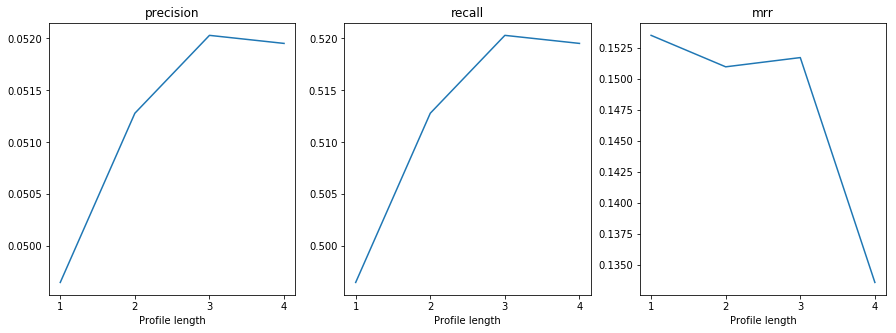

In [21]:
# show separate plots per metric
fig, axes = plt.subplots(nrows=1, ncols=len(METRICS), figsize=(15,5))
res_list_t = list(zip(*res_list))
for midx, metric in enumerate(METRICS):
    mvalues = [res_list_t[1][j][midx][1] for j in range(len(res_list_t[1]))]
    ax = axes[midx]
    ax.plot(given_k_list, mvalues)
    ax.set_title(metric)
    ax.set_xticks(given_k_list)
    ax.set_xlabel('Profile length')